# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make conclusions) then **text answer** is **mandatory** and **is** part of the task
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 

In [1]:
# Ozmaden Deniz BSE 196

from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model is parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

##### Put your markdown formulas here below:

##### $$\nabla_w L(w,w_0)= -\frac{1}{N} \sum_{i=1}^N \frac{exp(-y_i (w^Tx_i+w_0))}{1+exp(-y_i (w^Tx_i+w_0))} y_i x_i + \gamma sign(w)+ 2 \beta w $$

##### $$\nabla_{w_0} L(w,w_0)= -\frac{1}{N} \sum_{i=1}^N \frac{exp(-y_i (w^Tx_i+w_0))}{1+exp(-y_i (w^Tx_i+w_0))}y_i $$

#### 2. [0.5 points] Implement the Elastic Net loss (as a function)

**Reminder!**
Do not use loops in task 2 and task 3. Loss and grad functions should be implemented in matrix form, without loops.

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    
    """
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    """

    dotProd = np.dot(X, np.transpose(w))
    expPart = np.exp((dotProd + w0) * y * -1)
    summ = np.sum(1 + expPart)

    gammaPart = gamma * np.sum(np.abs(w)) # manhattan
    betaPart = beta * np.linalg.norm(w)**2 # euclidian

    result = summ + betaPart + gammaPart

    return result

#### 3. [0.5 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    '''

    dotProdInExp = np.dot(X, np.transpose(w))
    expPart = np.exp(-y * (dotProdInExp + w0))

    fractionPart = (y * expPart) / (expPart + 1)

    dotProd = np.dot(fractionPart, X)
    betaPart = 2 * beta * w
    gammaPart = gamma * np.sign(w)

    W_gradient = -1/len(X) * + dotProd + betaPart + gammaPart

    summ = np.sum((fractionPart))
    W0_gradient = -1/len(X) * summ

    return W_gradient, W0_gradient

#### Check yourself

In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):  
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge
        
        '''
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        # you may additional properties if you wish
        self.w0 = 0
        self.loss_history = []
        self.threshold = 0
        
    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X, y) dataset
        # save history of optimization steps
        
        self.w = np.zeros(X[0].size)

        iterations = 0
        while (iterations < self.max_iter):
            prev_w = self.w
            
            # log loss
            lossVal = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(lossVal)

            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)

            self.w = self.w - grad_w * self.learning_rate 
            self.w0 = self.w0 - grad_w0 * self.learning_rate
            if(self.tolerance >= np.linalg.norm(self.w - prev_w)):
                break
            
            iterations += 1
                      
        probabilities = self.predict_proba(X)

        # set new threshold
        self.falsePositive, self.truePositive, thresholds = roc_curve(y,  probabilities)
        index = np.argmax(np.sqrt((1 - self.falsePositive) * self.truePositive))
        self.threshold= thresholds[index]

        return self
     
    
    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X
        
        '''
        probabilities = self.predict_proba(X)
        return np.where(probabilities < self.threshold, -1, 1)

    def predict_proba(self, X):
        '''
        Function that estimates probabilities 

        '''
        dotProd = np.dot(X, self.w)
        proba = 1 / (np.exp(-self.w0 - dotProd) + 1)
        return proba

In [7]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [8]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

In [9]:
print(X.shape)
print(y.shape)

(180, 2)
(180,)


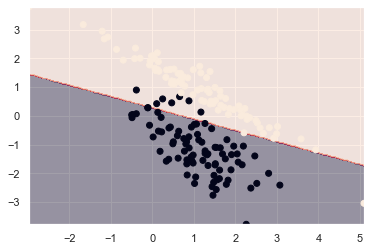

In [10]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

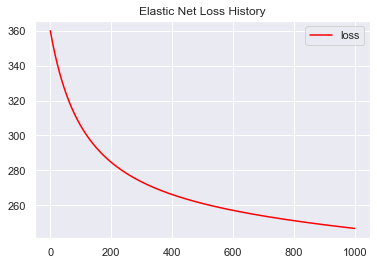

In [11]:
 # your code here
plt.title("Elastic Net Loss History")
plt.plot(model.loss_history, label = 'loss', color = 'red')
plt.legend()
plt.show()

## PART 2: Support Vector Machines

#### 6. [1 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [12]:
from sklearn.model_selection import train_test_split
dataset = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.svm import SVC

def createFromKernel(kernelName, regularizationParam, *params):
    if (kernelName == 'rbf' or kernelName == 'poly' or kernelName == 'sigmoid'):
        if (kernelName != 'poly'):
            return SVC( kernel = kernelName,
                        C = regularizationParam,
                        gamma = params[0])
        else:
            return SVC(kernel = kernelName, 
                        C = regularizationParam, 
                        gamma = params[0],
                        degree = params[1])
    else:
        return SVC(kernel = kernelName, C = regularizationParam)   


def testKernel(classifier, dataset):
    train_X, test_X, train_Y, test_Y = dataset
    classifier.fit(train_X, train_Y)
    predictions = classifier.predict(test_X)
    accuracyScore = accuracy_score(test_Y, predictions)
    rocScore = roc_auc_score(test_Y, predictions)
    fScore = f1_score(test_Y, predictions)
    return accuracyScore, rocScore, fScore


def plotResultsByKernel(kernelName, accuracy, roc_curve, f_score):
    plt.title(kernelName)
    plt.plot(accuracy, label = 'accuracy', color = 'blue')
    plt.plot(roc_curve, label = 'roc_auc', color = 'green')
    plt.plot(f_score, label = 'f1_score', color = 'red')
    plt.legend()
    plt.show()

In [14]:
def collectScores(dataset, kernelName, *params):
    accuracy = []
    roc_curve = []
    f_score = []
    regCoeffs = np.linspace(0.0001, 2, 300)
    for regC in regCoeffs:
        SVM_Classifier = createFromKernel(kernelName, regC, *params)
        accuracyScore, rocScore, fScore = testKernel(SVM_Classifier, dataset)
        accuracy.append(accuracyScore)
        roc_curve.append(rocScore)
        f_score.append(fScore)
    return accuracy, roc_curve, f_score

In [15]:
def plotResultsByKernel(name, accuracy, roc_curve, f_score):
    plt.title(name)
    plt.plot(accuracy, label = 'accuracy', color = 'blue')
    plt.plot(roc_curve, label = 'roc_auc', color = 'green')
    plt.plot(f_score, label = 'f1_score', color = 'violet')
    plt.legend()
    plt.show()

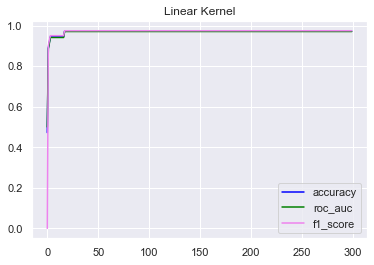

In [16]:
linear_accuracy, linear_roc_curve, linear_f_score = collectScores(dataset, 'linear')
plotResultsByKernel("Linear Kernel", linear_accuracy, linear_roc_curve, linear_f_score)

### Testing Linear Kernel. Nothing particularly interesting, regulariztion seems to have a huge effect, metrics don't vary that much.

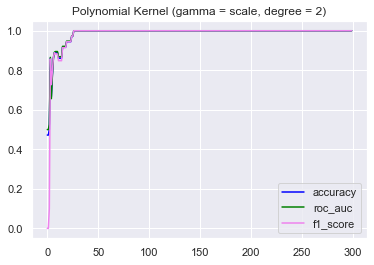

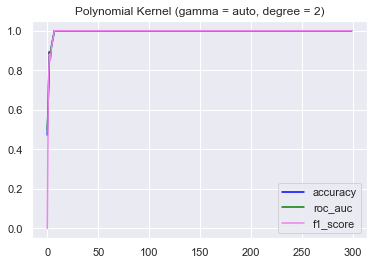

In [17]:
poly_accuracy, poly_roc_curve, poly_f_score = collectScores(dataset, 'poly', 'scale', 2)
plotResultsByKernel("Polynomial Kernel (gamma = scale, degree = 2)", poly_accuracy, poly_roc_curve, poly_f_score)

poly_accuracy, poly_roc_curve, poly_f_score = collectScores(dataset, 'poly', 'auto', 2)
plotResultsByKernel("Polynomial Kernel (gamma = auto, degree = 2)", poly_accuracy, poly_roc_curve, poly_f_score)

### Testing Polynomial Kernel with different hyperparameters. Wecan see that changing the way gamma is calculated seems to have a distinct positive effect to metric

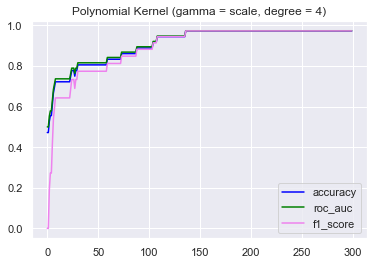

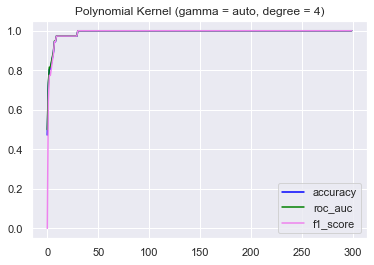

In [18]:
poly_accuracy, poly_roc_curve, poly_f_score = collectScores(dataset, 'poly', 'scale', 4)
plotResultsByKernel("Polynomial Kernel (gamma = scale, degree = 4)", poly_accuracy, poly_roc_curve, poly_f_score)


poly_accuracy, poly_roc_curve, poly_f_score = collectScores(dataset, 'poly', 'auto', 4)
plotResultsByKernel("Polynomial Kernel (gamma = auto, degree = 4)", poly_accuracy, poly_roc_curve, poly_f_score)


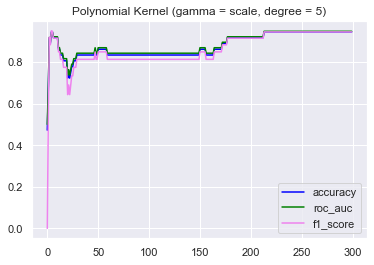

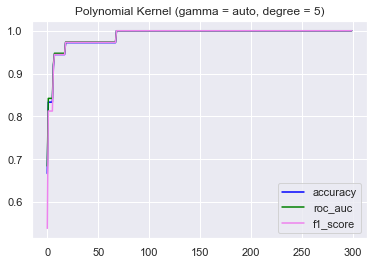

In [19]:
poly_accuracy, poly_roc_curve, poly_f_score = collectScores(dataset, 'poly', 'scale', 5)
plotResultsByKernel("Polynomial Kernel (gamma = scale, degree = 5)", poly_accuracy, poly_roc_curve, poly_f_score)

poly_accuracy, poly_roc_curve, poly_f_score = collectScores(dataset, 'poly', 'auto', 5)
plotResultsByKernel("Polynomial Kernel (gamma = auto, degree = 5)", poly_accuracy, poly_roc_curve, poly_f_score)

### From testing the degree hyperparameter one thing is certain - the higher the polynomial level - the worse the accuracy and other metrics get.

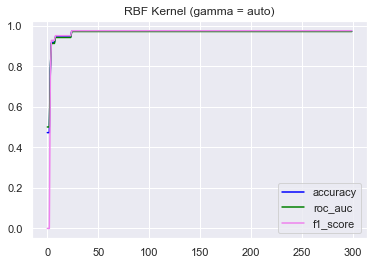

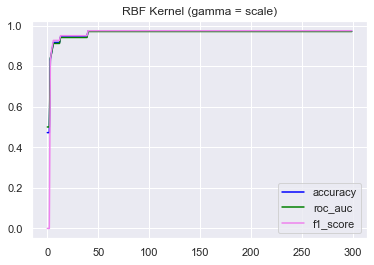

In [20]:
rbf_accuracy, rbf_roc_curve, rbf_f_score = collectScores(dataset, 'rbf', 'auto')
plotResultsByKernel("RBF Kernel (gamma = auto)", rbf_accuracy, rbf_roc_curve, rbf_f_score)

rbf_accuracy, rbf_roc_curve, rbf_f_score = collectScores(dataset, 'rbf', 'scale')
plotResultsByKernel("RBF Kernel (gamma = scale)", rbf_accuracy, rbf_roc_curve, rbf_f_score)

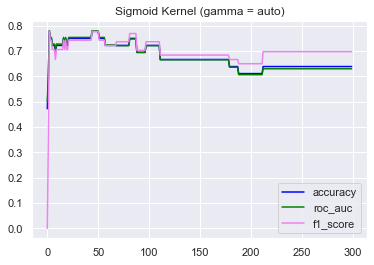

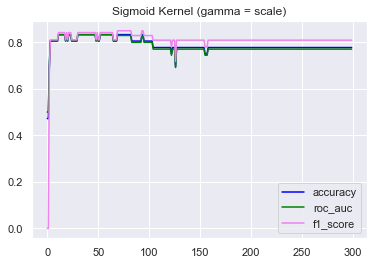

In [21]:
sigmoid_accuracy, sigmoid_roc_curve, sigmoid_f_score = collectScores(dataset, 'sigmoid', 'auto')
plotResultsByKernel("Sigmoid Kernel (gamma = auto)", sigmoid_accuracy, sigmoid_roc_curve, sigmoid_f_score)

sigmoid_accuracy, sigmoid_roc_curve, sigmoid_f_score = collectScores(dataset, 'sigmoid', 'scale')
plotResultsByKernel("Sigmoid Kernel (gamma = scale)", sigmoid_accuracy, sigmoid_roc_curve, sigmoid_f_score)


### This was done just because I was interested. I saw sigmoid in the documentation and said why not. Interestingly, futher regularization seems to have a negative effect on sigmoid function.

In [22]:
def plotResultsByScore(name, linear, poly, rbf, sigmoid):
    plt.title(name)
    plt.plot(linear, label = 'Linear', color = 'blue')
    plt.plot(poly, label = 'Polynomial', color = 'green')
    plt.plot(rbf, label = 'RBF', color = 'red')
    plt.plot(sigmoid, label = 'Sigmoid', color = 'orange')
    plt.legend()
    plt.show()

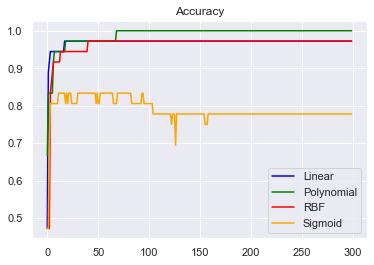

In [23]:
plotResultsByScore("Accuracy", linear_accuracy, poly_accuracy, rbf_accuracy, sigmoid_accuracy)

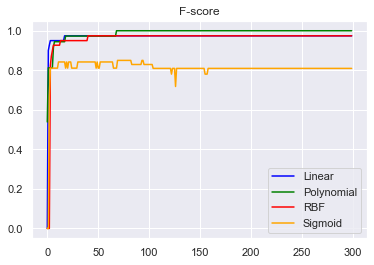

In [24]:
plotResultsByScore("F-score", linear_f_score, poly_f_score, rbf_f_score, sigmoid_f_score)

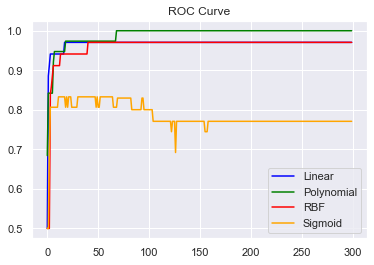

In [25]:
plotResultsByScore("ROC Curve", linear_roc_curve, poly_roc_curve, rbf_roc_curve, sigmoid_roc_curve)

#### It really does seem like the rate of regularization plays key role in overfitting for all kernels. Only sigmoid gets over time. Polynomial overall has the best metrics (but linear leads in the beginning), although that shifts very much with the value of degree hyperparameter (in graphs above it has the default value of 3).

## PART 3: Natural Language Processing

#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: [0.5 point]
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset  [1.5 point]
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [26]:
import nltk
from nltk import tokenize, download

download('punkt')
download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Denis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Denis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
from nltk.corpus import stopwords

import string
import re

# we used this during the seminar
import pymorphy2

def getSentences(filepath):
    min_length = 15
    stop_words = nltk.corpus.stopwords.words('russian')
    
    text = ""
    with open(filepath, "r", encoding="utf8") as f:
        text = f.read()
        text = text.replace('\n', '. ').replace('...',' ').replace('--', ' ').replace('-', ' ')
        # some punctuations are not catched by nltk

    sentences = tokenize.sent_tokenize(text)
    sentences = [s for s in sentences if min_length < len(s)]

    morph = pymorphy2.MorphAnalyzer()

    new_sentences = []
    for s in sentences:
        
        words = tokenize.word_tokenize(s)

        words = [word.lower() for word in words]

        words = [word for word in words if (word not in stop_words)]

        words = [word + " " for word in words if (word not in string.punctuation)]

        # ATTENTION
        # ENABLE WITH CAUTION
        # THIS WILL LITERALLY LAST FOR ETERNITY
        words = [morph.parse(word)[0].normal_form for word in words]

        result = ""
        for w in words:
            new_word = re.sub(r'[0-9]+', '', w)
            result += new_word
        # getting rid of numbers

        new_sentences.append(result)

    return new_sentences

In [28]:
import glob

def get_text(path):
    text = []
    for file in glob.glob(path):
        text += getSentences(file)
    return text

gogol_text = get_text('prose/Gogol/*.txt')
dostoevsky_text = get_text('prose/Dostoevsky/*.txt')
herzen_text = get_text('prose/Herzen/*.txt')
lermontov_text = get_text('prose/Lermontov/*.txt')
pushkin_text = get_text('prose/Pushkin/*.txt')
tolstoy_text = get_text('prose/Tolstoy/*.txt')

In [29]:
def get_len(name, data):
    print("{} sentences length: {}".format(name, len(data)))
    return len(data)

summ = get_len('Gogol', gogol_text)
summ += get_len('Dostoevsky', dostoevsky_text)
summ += get_len('Herzen', herzen_text)
summ += get_len('Lermontov', lermontov_text)
summ += get_len('Pushkin', pushkin_text)
summ += get_len('Tolstoy', tolstoy_text)

print("Whole dataset length: {}".format(summ))

Gogol sentences length: 21286
Dostoevsky sentences length: 108434
Herzen sentences length: 15714
Lermontov sentences length: 4543
Pushkin sentences length: 9104
Tolstoy sentences length: 81391
Whole dataset length: 240472


In [30]:
gogol_labels = ['Гоголь'] * len(gogol_text)
dostoevsky_labels = ['Достоевский'] * len(dostoevsky_text)
herzen_labels = ['Герцен'] * len(herzen_text)
lermontov_labels =['Лермонтов'] * len(lermontov_text)
pushkin_labels = ['Пушкин'] * len(pushkin_text)
tolstoy_labels = ['Толстой'] * len(tolstoy_text)

In [31]:
def form_dataset_for_author(text, labels, k_coeff):
    dataset = pd.DataFrame()
    dataset['text'] = text[:k_coeff]
    dataset['author'] = labels[:k_coeff]
    return dataset

gogol_dataset = form_dataset_for_author(gogol_text, gogol_labels, 20000)
dostoevsky_dataset = form_dataset_for_author(dostoevsky_text, dostoevsky_labels, 40000)
herzen_dataset = form_dataset_for_author(herzen_text, herzen_labels, 15000)
lermontov_dataset = form_dataset_for_author(lermontov_text, lermontov_labels, 3000)
pushkin_dataset = form_dataset_for_author(pushkin_text, pushkin_labels, 7000)
tolstoy_dataset = form_dataset_for_author(tolstoy_text, tolstoy_labels, 30000)

In [32]:
gogol_dataset

,text,author
0,николай васильевич гоголь,Гоголь
1,попробуй взглянуть молнию раскроивши черные уг...,Гоголь
2,таковы очи альбанки аннунциаты,Гоголь
3,напоминает те античные времена оживлялся мрамо...,Гоголь
4,густая смола волос тяжеловесной косою вознесла...,Гоголь
...,...,...
19995,охватывать одно целое одно общее выраженье угл...,Гоголь
19996,притом нужно прибавить писавшихся других притя...,Гоголь
19997,дамы требовали преимущественно душа характер и...,Гоголь
19998,словом лицо засмотреться совершенно влюбиться,Гоголь


In [33]:
frames = [gogol_dataset, dostoevsky_dataset, herzen_dataset, lermontov_dataset, pushkin_dataset, tolstoy_dataset]
whole_dataset = pd.concat(frames)

In [34]:
whole_dataset

,text,author
0,николай васильевич гоголь,Гоголь
1,попробуй взглянуть молнию раскроивши черные уг...,Гоголь
2,таковы очи альбанки аннунциаты,Гоголь
3,напоминает те античные времена оживлялся мрамо...,Гоголь
4,густая смола волос тяжеловесной косою вознесла...,Гоголь
...,...,...
29995,– стивы – отвечал неохотно ..,Толстой
29996,– отчего показал,Толстой
29997,тайна стивой мной,Толстой
29998,вронский воротил камердинера велел принесть де...,Толстой


In [35]:
from sklearn.feature_extraction.text import CountVectorizer

def bag_of_words(author_name, data):
    sentences = data['text'].tolist()
    vctrztr = CountVectorizer()
    vctrztr.fit(sentences)

    # cool feature from the seminar, I use it just for general understanding
    print("Top 15 words of {}". format(author_name))
    print(vctrztr.get_feature_names()[:15])

    vectorized_sentences = vctrztr.transform(sentences)
    return vectorized_sentences
    #return vectorized_sentences.todense()


In [36]:
gogol_bag_vector = bag_of_words('Gogol', gogol_dataset)
dostoevsky_bag_vector = bag_of_words('Dostoevsky', dostoevsky_dataset)
herzen_bag_vector = bag_of_words('Herzen', herzen_dataset)
lermontov_bag_vector = bag_of_words('Lermontov', lermontov_dataset)
pushkin_bag_vector = bag_of_words('Pushkin', pushkin_dataset)
tolstoy_bag_vector = bag_of_words('Tolstoy', tolstoy_dataset)

Top 15 words of Gogol
['allegria', 'amore', 'amour', 'appele', 'ave', 'baiser', 'belle', 'benvetino', 'bestia', 'bonjour', 'bеllа', 'casa', 'che', 'chere', 'chi']
Top 15 words of Dostoevsky
['aber', 'académicien', 'accident', 'accoinpagnerez', 'ad', 'adieu', 'affaire', 'ah', 'ai', 'albert', 'alienum', 'ami', 'amie', 'amore', 'amour']
Top 15 words of Herzen
['aber', 'abime', 'abreuve', 'absurdes', 'accroire', 'accusateur', 'acquérir', 'adansonia', 'adolescentes', 'aer', 'aeternitatis', 'agé', 'ah', 'ai', 'aime']
Top 15 words of Lermontov
['aimer', 'autrement', 'car', 'cavalier', 'charmant', 'cher', 'christophe', 'circassien', 'couleur', 'craignez', 'dangereux', 'de', 'degoutante', 'dieu', 'en']
Top 15 words of Pushkin
['abondance', 'abord', 'abri', 'affreuse', 'agitant', 'ai', 'ailleurs', 'aimable', 'aisé', 'ait', 'allein', 'allégresse', 'als', 'altesse', 'amanti']
Top 15 words of Tolstoy
['aber', 'ablutions', 'admirable', 'adore', 'adrienne', 'affaire', 'affaires', 'affreux', 'ah', 'ai

In [37]:
whole_bag_vector = bag_of_words('the whole Dataset', whole_dataset)

Top 15 words of the whole Dataset
['aber', 'abime', 'ablutions', 'abondance', 'abord', 'abreuve', 'abri', 'absurdes', 'académicien', 'accident', 'accoinpagnerez', 'accroire', 'accusateur', 'acquérir', 'ad']


### I guess russian authors turned out to be french! Bag of words function seems not to see cyrilic words. There is nothing in the task that says that we should delete french words, so I guess this should be correct

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tf_idf(author_name, data):
    sentences = data['text'].tolist()
    vctrztr = TfidfVectorizer(max_features = 100)
    vctrztr.fit(sentences)

    print("Top 15 words of {}". format(author_name))
    print(vctrztr.get_feature_names()[:15])

    vectorized_sentences = vctrztr.transform(sentences)
    return vectorized_sentences
    #return vectorized_sentences.to_dense()

In [39]:
gogol_tf_vector = tf_idf('Gogol', gogol_dataset)
dostoevsky_tf_vector = tf_idf('Dostoevsky', dostoevsky_dataset)
herzen_tf_vector = tf_idf('Herzen', herzen_dataset)
lermontov_tf_vector = tf_idf('Lermontov', lermontov_dataset)
pushkin_tf_vector = tf_idf('Pushkin', pushkin_dataset)
tolstoy_tf_vector = tf_idf('Tolstoy', tolstoy_dataset)

Top 15 words of Gogol
['бог', 'богу', 'ваше', 'верно', 'весь', 'видно', 'вместе', 'вместо', 'вовсе', 'время', 'всем', 'вся', 'глаза', 'говорил', 'говорит']
Top 15 words of Dostoevsky
['алеша', 'ах', 'брат', 'буду', 'вами', 'ваше', 'весь', 'вовсе', 'время', 'всем', 'вся', 'всё', 'глаза', 'говорил', 'говорит']
Top 15 words of Herzen
['бельтов', 'весь', 'вместе', 'вовсе', 'время', 'всем', 'всякий', 'глаза', 'говорил', 'голову', 'две', 'делать', 'деле', 'дело', 'день']
Top 15 words of Lermontov
['азамат', 'александрович', 'ашик', 'бог', 'бэла', 'верно', 'взял', 'вид', 'видел', 'видно', 'возле', 'время', 'глаза', 'говорил', 'голову']
Top 15 words of Pushkin
['de', 'батюшка', 'бог', 'ваше', 'велел', 'верстах', 'владимир', 'войска', 'времени', 'время', 'всем', 'вскоре', 'генерал', 'глаза', 'года']
Top 15 words of Tolstoy
['александрович', 'алексей', 'анна', 'аркадьич', 'видел', 'вместе', 'время', 'вронский', 'всем', 'всё', 'вышел', 'глаза', 'глядя', 'говорил', 'говорила']


In [40]:
whole_tf_vector = tf_idf('the whole Dataset', whole_dataset)

Top 15 words of the whole Dataset
['алеша', 'бог', 'брат', 'ваше', 'весь', 'видел', 'вместе', 'время', 'всем', 'вся', 'всё', 'глаза', 'говорил', 'говорит', 'говорить']


In [41]:
whole_tf_vector.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

### The tf-idf shows much important a word is to the dataset. It increases proportionally to the number of word appearances in the dataset. This vector hold these values.

In [41]:
#whole_bag_vector.todense()

### For some weird an error occurs here and  Windows tells me that this ipynb is asking for too much RAM when trying to densify this vector, although I have huge amounts of RAM. Is this array really a bit too much? Everything should be correct, but I just can't display it on the notebook. Weird stuff

### Anyway this vector holds numbers of occurences of text in sentence.

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. [1 point]
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. [1 point]
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

**HINT:** In the task 8.2 you should analyze models for binary classification task. How do you think the AUC_ROC should be high? Is the 0.6 enough for us?

In [51]:
new_frames = [gogol_dataset, herzen_dataset]
new_dataset = pd.concat(new_frames)
new_dataset

,text,author
0,николай васильевич гоголь,Гоголь
1,попробуй взглянуть молнию раскроивши черные уг...,Гоголь
2,таковы очи альбанки аннунциаты,Гоголь
3,напоминает те античные времена оживлялся мрамо...,Гоголь
4,густая смола волос тяжеловесной косою вознесла...,Гоголь
...,...,...
14995,сказал причинах моего появления,Герцен
14996,велел подать дело,Герцен
14997,резолюция подготовлена попросил обратить внима...,Герцен
14998,`` облегчающие обстоятельства '' согласился во...,Герцен


Gogol dataset is bigger than Herzen dataset by 35.45882652411862 % points


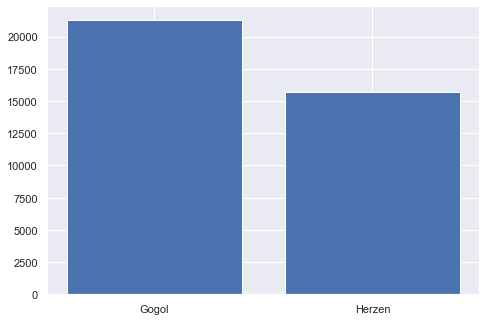

In [52]:
gogol_length = len(gogol_text)
herzen_length = len(herzen_text)

pct_change = ((gogol_length - herzen_length) / herzen_length) * 100
print("Gogol dataset is bigger than Herzen dataset by {} % points".format(pct_change))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
authors = ['Gogol', 'Herzen']
sizes = [len(gogol_text), len(herzen_text)]
ax.bar(authors, sizes)
plt.show()

### The difference whilst not small, is not really a huge "imbalance"

In [53]:
from sklearn.model_selection import train_test_split

# transform y_test into numbered vector
labels = []
for name in new_dataset['author'].tolist():
    if name == 'Гоголь':
        labels.append(-1)
    elif (name == 'Герцен'):
        labels.append(1)

X_train, X_test, y_train, y_test = train_test_split(new_dataset['text'], labels, test_size = 0.25, random_state = 0)

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

# using tf_idf to transform the text part of the dataset into numbered vectors
def tf_idf_transform(train_text, test_text):
    vctrztr = TfidfVectorizer()
    vctrztr.fit(train_text)
    
    X_train = vctrztr.transform(train_text)
    X_test = vctrztr.transform(test_text)

    return X_train.todense(), X_test.todense()

In [55]:
X_train, X_test = tf_idf_transform(X_train, X_test)

In [62]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# these functions are really just things we went over during the seminars
# But nonetheless I changed them a little because I am afraid of cheating accusations 0_0

def plot_confusion_matriix(y_test, pred):
    plt.title("Confusion matrix ")
    matrix_labels = ['positive', 'negative']
    sns.heatmap(data=confusion_matrix(y_test, pred),
                xticklabels= matrix_labels, yticklabels = matrix_labels,  
                annot = True, fmt="d", cbar=False)
    plt.show()

def collect_metrics(y_test, predictions, probabalities):
    accuracy = accuracy_score(y_test, predictions)
    f_score = f1_score(y_test, predictions, average = 'macro')
    roc_curve = roc_auc_score(y_test, probabalities[:,1])

    recall = recall_score(y_test, predictions, average = 'macro')
    precision = precision_score(y_test, predictions, average = 'macro')

    print("Accuracy: {0:6.2f}".format(accuracy))
    print("F-Score: {0:6.2f}".format(f_score))
    print("ROC Curve: {0:6.2f}".format(roc_curve))
    
    print("Recall: {0:6.2f}".format(recall))
    print("Precision: {0:6.2f}".format(precision))


 ### I tried using Logit (my own class), however there was a very peculiar mistake happening during the gradient calculation (np.arrays having different sizes and therefore not multiplicating). I spent days on the problem, I am sure the gradient formula is correct. But there was simply nothing I could do. So I used LogisticRegression class from sklearn. Yeah, it's wrong, but I hope I get at least some points for the task.

In [57]:
#model = Logit(0,0)

#X_train = np.transpose(y_train)
# print(X_train.shape)

# y_train = np.array(y_train)
#y_train = np.expand_dims(y_train, axis=0)
#y_train = np.transpose(y_train)
# print(y_train.shape)

#model.fit(X_train, y_train)

#pred = model.predict(X_test)
#proba = model.predict_proba(X_test)

(26250, 59557)


AttributeError: 'list' object has no attribute 'shape'

In [58]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(random_state = 0)
logistic_regression.fit(X_train, y_train)

LogisticRegression(random_state=0, verbose=False)

Logistic regression results on train: 


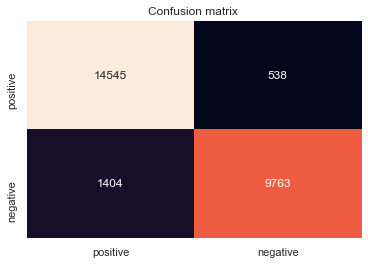

Accuracy:   0.93
F-Score:   0.92
ROC Curve:   0.98
Recall:   0.92
Precision:   0.93


In [63]:
predictions = logistic_regression.predict(X_train)
probabilities = logistic_regression.predict_proba(X_train)

print("Logistic regression results on train: ")
plot_confusion_matriix(y_train, predictions)
collect_metrics(y_train, predictions, probabilities)

Logistic regression results on test: 


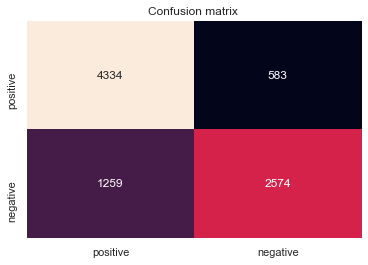

Accuracy:   0.79
F-Score:   0.78
ROC Curve:   0.88
Recall:   0.78
Precision:   0.80


In [64]:
predictions = logistic_regression.predict(X_test)
probabilities = logistic_regression.predict_proba(X_test)

print("Logistic regression results on test: ")
plot_confusion_matriix(y_test, predictions)
collect_metrics(y_test, predictions, probabilities)

### I have no idea what happened, but the classifications below go on forever. I tried everything I can and it still didn't help. The logic of GridSearchCV should be correct, at least I looked at seminar 6 and tried to replicate what went over there. But I can't get the results! Or analyze them, or plot them, or make conslusions...

In [65]:
svc_classifier = SVC(kernel = 'linear', probability = True)
svc_classifier.fit(X_train, y_train)

In [ ]:
predictions = svc_classifier.predict(X_train)
probabilities = svc_classifier.predict_proba(X_train)

print("Linear SVC results on train: ")
plot_confusion_matriix(y_train, predictions)
collect_metrics(y_train, predictions, probabilities)

In [ ]:
predictions = svc_classifier.predict(X_test)
probabilities = svc_classifier.predict_proba(X_test)

print("Linear SVC results on test: ")
plot_confusion_matriix(y_test, predictions)
collect_metrics(y_test, predictions, probabilities)

In [ ]:
from sklearn.model_selection import GridSearchCV

logistic_regression = LogisticRegression()
params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 100, 1000], 'penalty': ['l1', 'l2', 'elasticnet']}
classifier = GridSearchCV(logistic_regression, params, scoring = 'roc_auc')

classifier.fit(X_train, y_train)

print('Found best hyperparameters: ', classifier.best_params_)

predictions = classifier.predict(X_test)
probabilities  = classifier.predict_proba(X_test)

plot_confusion_matriix(y_test, predictions)
collect_metrics(y_test, predictions, probabilities)

In [ ]:
svm_grid = SVC(probability = True)
params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 100, 1000], 'kernel': ('linear', 'poly', 'rbf')}
classifier = GridSearchCV(svm_grid, params, scoring = 'roc_auc')

classifier.fit(X_train, y_train)

print('Found best hyperparameters: ', classifier.best_params_)

predictions = classifier.predict(X_test)
probabilities  = classifier.predict_proba(X_test)

plot_confusion_matriix(y_test, predictions)
collect_metrics(y_test, predictions, probabilities)

#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score). **HINT:** Do not forget about set jobs=-1 in the GridSearchCV init to speed up calculations.
* make conclusions about the model